In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import json
import argparse
import copy

import torch
from model import my_model, MyDataset

from matplotlib.colors import LogNorm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

opt:  Namespace(output_dir='./output/transformer1', max_length=30, use_loss_mono=False, use_rad=True, seed=12345, data_dir='./training_data', train_ratio=0.9, batch_size=512, num_epochs=10, lr=0.001, dropout=0.0, use_sampler=True, model_name='transformer1', d_model=128, num_layers=4, num_heads=8, num_features_out=100, num_features_in=2)
Transformer1(
  (embedding_layers): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
  )
  (context_embedding_layers): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): N

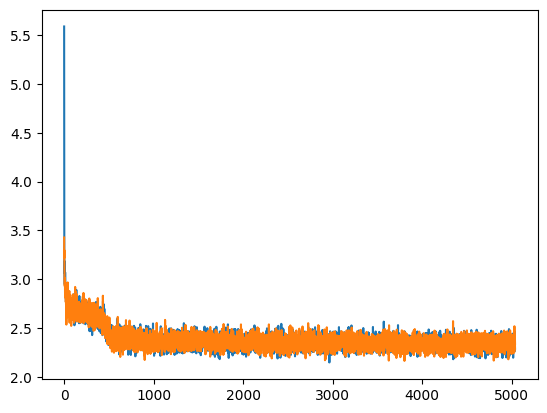

In [3]:
model_dir = "./output/transformer1"
#model_dir = "./output/transformer2"
#model_dir = "./output/transformer3"
#model_dir = "./output/best"

data_dir = "TNG_data"

### plot loss 
loss = np.loadtxt(f"{model_dir}/log.txt", comments="#")
plt.figure()
plt.plot(loss[:,0], label="train")
plt.plot(loss[:,1], label="val")
#plt.yscale("log")

### load parameters
with open(f"{model_dir}/args.json", "r") as f:
    opt = json.load(f, object_hook=lambda d: argparse.Namespace(**d))
print("opt: ", opt)

norm_params = np.loadtxt("norm_params.txt")
xmin, xmax = norm_params[0]
ymin, ymax = norm_params[1]
ymin2, ymax2 = norm_params[2]

### load model
model = my_model(opt)
model.to(device)

model.load_state_dict(torch.load(f"{model_dir}/model.pth"))
model.eval()
print(model)

In [4]:
### True data ###
ndata = None
#ndata = 10000
dataset_true = MyDataset(f"./TNG_data", max_length=opt.max_length, norm_params=norm_params, ndata=ndata, use_dist=opt.use_rad)
x_true = dataset_true.x
y_true = dataset_true.y_padded
x_true_Msun = x_true * (xmax - xmin) + xmin

### model output ###
count = 0
generated = []
while count < len(x_true):
    tmp = x_true[count:count+opt.batch_size].to(device)
    gen, _ = model.generate(tmp)
    generated.append(gen)
    count += opt.batch_size
generated = torch.cat(generated, dim=0)

x_true = x_true[:,0].detach().cpu().numpy() # (batch, num_condition) -> (batch,)
y_true = y_true.detach().cpu().numpy()
generated = generated.detach().cpu().numpy()

In [5]:
### set threshold
threshold1 = 1. / opt.num_features_out
threshold2 = ( np.log10(0.1) - ymin ) / ( ymax - ymin)
#threshold = 0.5 * (threshold1 + threshold2)
threshold = threshold2
bin_of_threshold = int(threshold * opt.num_features_out)
print(threshold)
print(bin_of_threshold)

def calc_length(x, ref_param=0, skip_length=1): 
    # skip the first element (central)
    # generated: (num_samples, seq_length, num_features_in)
    num_samples, seq_length, num_features_in = x.shape
    length = np.zeros(num_samples, dtype=int)
    for i in range(num_samples):
        for j in range(skip_length, seq_length):
            if x[i,j,ref_param] < threshold:
                break
        length[i] = j
    return length

### calculate length ###
length_true = calc_length(y_true)
length_generated = calc_length(generated)

### binning ###
nbins = 20
logm_bins = np.linspace(0, 1, nbins+1)
logm_bins_Msun = logm_bins * (xmax - xmin) + xmin
logm_bin_indices_true = np.digitize(x_true, logm_bins) - 1 # (num_samples,)

y_bins = np.linspace(0, 1, nbins+1)
y_bins_Msun_yr = y_bins * (ymax - ymin) + ymin
y_bins_Mpc_h = y_bins * (ymax2 - ymin2) + ymin2
y_bin_indices_true = np.digitize(y_true, y_bins) - 1 # (num_samples, seq_length, num_params)
y_bin_indices_generated = np.digitize(generated, y_bins) - 1 # (num_samples, seq_length, num_params)
 
length_bins = np.arange(1, opt.max_length+1)
length_bin_indices_true = np.digitize(length_true, length_bins) - 1 # (num_samples,)
length_bin_indices_generated = np.digitize(length_generated, length_bins) - 1 # (num_samples,)
 
# Total SFR of halo
mask = np.arange(opt.max_length) < length_true[:,None]
output_masked = (10**y_true[:,:,0]) * mask
y_true_sat_tot = np.sum(output_masked[:,1:], axis=1)
y_true_tot = np.sum(output_masked, axis=1)

mask = np.arange(opt.max_length) < length_generated[:,None]
output_masked = (10**generated[:,:,0]) * mask
y_generated_sat_tot = np.sum(output_masked[:,1:], axis=1)
y_generated_tot = np.sum(output_masked, axis=1)

y_true_sat_tot = np.log10(y_true_sat_tot) # (num_samples,)
y_true_tot = np.log10(y_true_tot) # (num_samples,)
y_generated_sat_tot = np.log10(y_generated_sat_tot) # (num_samples,)
y_generated_tot = np.log10(y_generated_tot) # (num_samples,)

0.04761904761904761
4


/tmp/ipykernel_1768348/2240999735.py:53: RuntimeWarning: divide by zero encountered in log10
  y_true_sat_tot = np.log10(y_true_sat_tot) # (num_samples,)
/tmp/ipykernel_1768348/2240999735.py:55: RuntimeWarning: divide by zero encountered in log10
  y_generated_sat_tot = np.log10(y_generated_sat_tot) # (num_samples,)


0.2930: 0.6431 0.0046 | 
0.2930: 0.0015 0.4175 | 
0.2835: 0.5780 0.2470 0.2125 0.1301 0.1079 0.0008 | 
0.2835: 0.0007 0.3598 0.0055 0.4070 0.0029 0.0091 | 
0.2991: 0.5734 0.1153 0.0088 | 
0.2991: 0.0022 0.3962 0.4352 | 
0.2545: 0.4863 0.4257 0.2024 0.0079 | 
0.2545: 0.0097 0.0098 0.3588 0.4728 | 
0.2861: 0.6083 0.4039 0.0050 | 
0.2861: 0.0040 0.3043 0.0035 | 
0.2862: 0.6616 0.0041 | 
0.2862: 0.0078 0.4801 | 
0.2921: 0.5289 0.2364 0.0626 0.0081 | 
0.2921: 0.0075 0.4706 0.0054 0.0022 | 
0.2686: 0.5496 0.3207 0.2060 0.0064 | 
0.2686: 0.0020 0.3436 0.4189 0.0023 | 
0.2676: 0.5426 0.5500 0.0056 | 
0.2676: 0.0075 0.0028 0.0034 | 
0.2965: 0.6146 0.4047 0.1969 0.0993 0.1003 0.0041 | 
0.2965: 0.0082 0.3462 0.2714 0.0075 0.0035 0.0054 | 


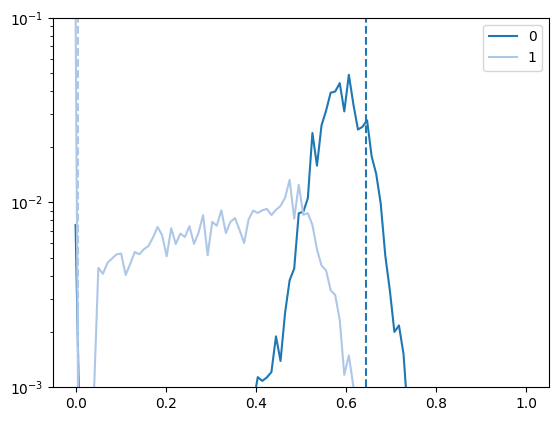

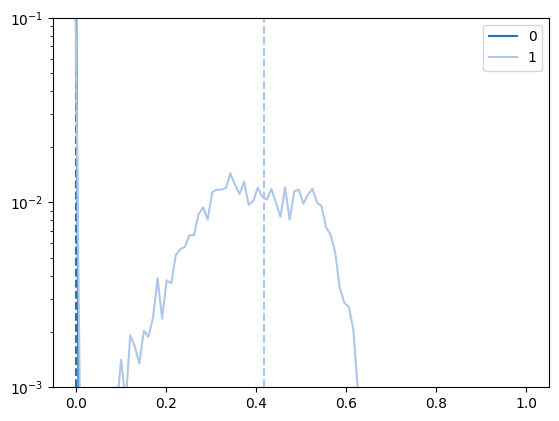

In [5]:
## Quick check of the output and probability
ibin = 5
nsample = 10
x_random = torch.rand(nsample).to(device) 
x_random = x_random * (logm_bins[ibin+1] - logm_bins[ibin]) + logm_bins[ibin]
generated_test, prob = model.generate(x_random)
generated_test = generated_test.detach().cpu().numpy()
prob = prob.detach().cpu().numpy()

length_generated_test = calc_length(generated_test)

cmap = plt.get_cmap("tab20")
colors = [cmap(i) for i in range(20)] * 10

for i, (x, g) in enumerate(zip(x_random, generated_test)):
    for iparam in range(opt.num_features_in):
        print(f"{x_random[i].item():.4f}: ", end="")
        for j, gg in enumerate(g[:,iparam]):
            print(f"{gg:.4f} ", end="")
            if j == length_generated_test[i]:
                break

        print("| ")

        if i == 0:
            plt.figure()
            ylim = 0.001, 0.1
            for k in range(j+1):
                plt.plot(np.linspace(0, 1, opt.num_features_out), prob[i,k,iparam], label=k, color=colors[k])
                plt.vlines(g[k,iparam], *ylim, colors=colors[k], linestyles="dashed")
            plt.ylim(*ylim)
            plt.yscale("log")
            plt.legend()
        #break

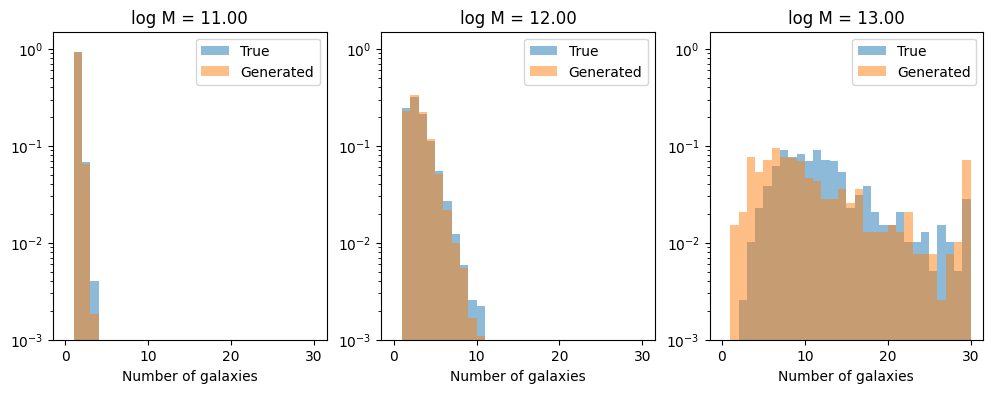

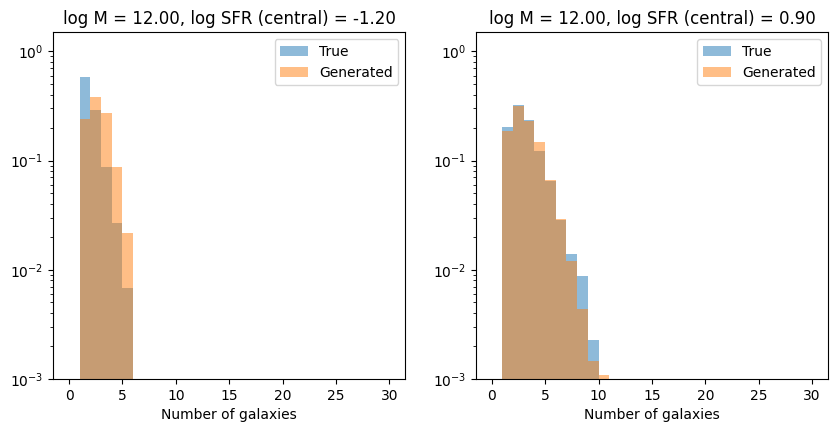

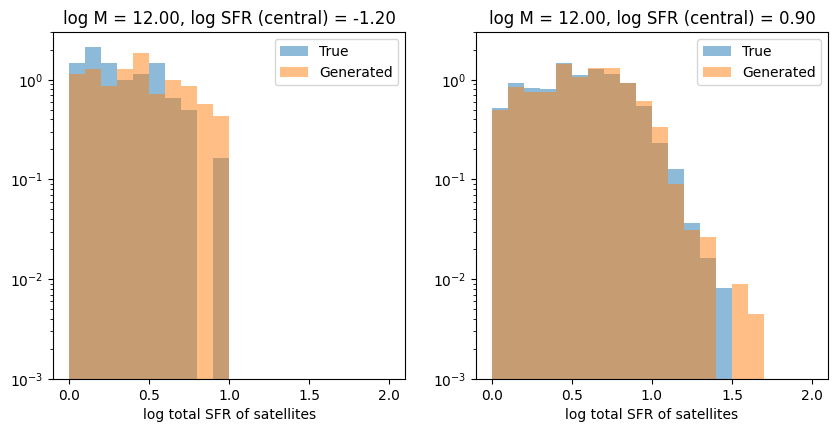

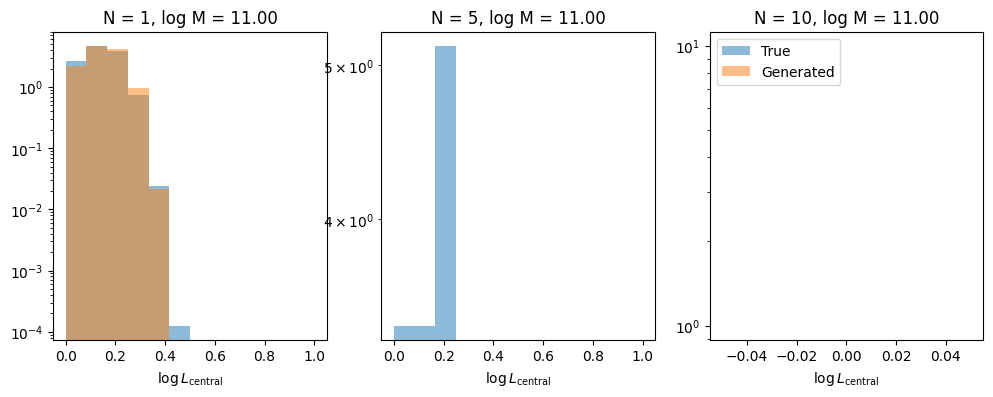

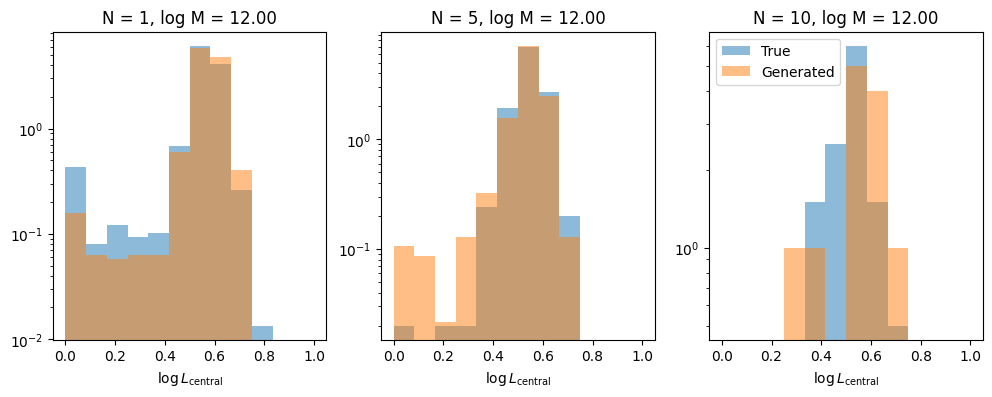

In [34]:
### Histograms 
density = False 
density = True

list_to_show = [0, 5, 10]
plt.figure(figsize=(len(list_to_show)*4, 4))
for count, i in enumerate(list_to_show):
    plt.subplot(1,len(list_to_show),count+1)
    plt.title(f"log M = {logm_bins_Msun[i]:.2f}")
    indices = np.where(logm_bin_indices_true == i)[0]
    plt.hist(length_true[indices], range=(0,opt.max_length), bins=opt.max_length, alpha=0.5, density=density, label="True", ls="-")
    plt.hist(length_generated[indices], range=(0,opt.max_length), bins=opt.max_length, alpha=0.5, density=density, label="Generated", ls="--")
    plt.yscale("log")
    plt.xlabel("Number of galaxies")
    if density:
        plt.ylim([1e-3, 1.5])
    else:
        plt.ylim([5e-1, 5e5])
    plt.legend()

list_to_show = [5]
y_list_to_show = [0, 10]
cmap = plt.get_cmap("tab20")
colors = [cmap(i) for i in range(20)] * 10
plt.figure(figsize=(len(y_list_to_show)*5, len(list_to_show)*4+0.5))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
count = 0
for i in list_to_show:
    base_mask = (logm_bin_indices_true == i)

    for j in y_list_to_show:
        plt.subplot(len(list_to_show),len(y_list_to_show),count+1)
        plt.title(f"log M = {logm_bins_Msun[i]:.2f}, log SFR (central) = {y_bins_Msun_yr[j]:.2f}")

        indices = np.where((y_bin_indices_true[:,0,0] == j) & base_mask )[0]
        plt.hist(length_true[indices], range=(0,opt.max_length), bins=opt.max_length, alpha=0.5, density=density, label="True", ls="-")
        indices = np.where((y_bin_indices_generated[:,0,0] == j) & base_mask)[0]
        plt.hist(length_generated[indices], range=(0,opt.max_length), bins=opt.max_length, alpha=0.5, density=density, label="Generated", ls="--")
        plt.yscale("log")
        plt.xlabel("Number of galaxies")

        count += 1

        if density:
            plt.ylim([1e-3, 1.5])
        else:
            plt.ylim([5e-1, 5e2])
        plt.legend()

list_to_show = [5]
y_list_to_show = [0, 10]
cmap = plt.get_cmap("tab20")
colors = [cmap(i) for i in range(20)] * 10
plt.figure(figsize=(len(y_list_to_show)*5, len(list_to_show)*4+0.5))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
count = 0
for i in list_to_show:
    base_mask = (logm_bin_indices_true == i)

    for j in y_list_to_show:
        plt.subplot(len(list_to_show),len(y_list_to_show),count+1)
        plt.title(f"log M = {logm_bins_Msun[i]:.2f}, log SFR (central) = {y_bins_Msun_yr[j]:.2f}")

        indices = np.where((y_bin_indices_true[:,0,0] == j) & base_mask )[0]
        plt.hist(y_true_sat_tot[indices], range=(0,2), bins=20, alpha=0.5, density=density, label="True", ls="-")
        indices = np.where((y_bin_indices_generated[:,0,0] == j) & base_mask)[0]
        plt.hist(y_generated_sat_tot[indices], range=(0,2), bins=20, alpha=0.5, density=density, label="Generated", ls="--")
        plt.yscale("log")
        plt.xlabel("log total SFR of satellites")

        count += 1

        if density:
            plt.ylim([1e-3, 3])
        else:
            plt.ylim([5e-1, 5e2])
        plt.legend()

list_to_show = [0, 5]
length_list_to_show = [1, 5, 10]
for i_logm in list_to_show:
    base_mask = (logm_bin_indices_true == i_logm)
    #base_mask = np.ones(len(logm_bin_indices_true), dtype=bool)
    #base_mask = (i_logm < logm_bin_indices_true) & (logm_bin_indices_true < i_logm + 5)
    bins_l = 12
    for iparam in range(1): # only for the first parameter    
        plt.figure(figsize=(len(length_list_to_show)*4, 4))
        for count, i in enumerate(length_list_to_show):
            plt.subplot(1, len(length_list_to_show), count+1)
            plt.title(f"N = {i}, log M = {logm_bins_Msun[i_logm]:.2f}")
            indices = np.where((length_bin_indices_true == i-1) & base_mask )[0]
            plt.hist(y_true[indices,0,iparam], range=(0,1), bins=bins_l, alpha=0.5, density=density, label="True", ls="-")
            indices = np.where((length_bin_indices_generated == i-1) & base_mask)[0]
            plt.hist(generated[indices,0,iparam], range=(0,1), bins=bins_l, alpha=0.5, density=density, label="Generated", ls="-")

            if iparam == 0:
                plt.xlabel(r"$\log L_{\rm central}$")
            if iparam == 1:
                plt.xlabel(r"$\log d_{\rm satellite}$")
                
            plt.yscale("log")
            if not density:
                plt.ylim([5e-1, 1e5])
        plt.legend()

In [10]:
### Histograms 
density = False 
density = True

y_bin_indices_true = np.digitize(y_true, y_bins) - 1 # (num_samples, seq_length, num_params)
y_bin_indices_generated = np.digitize(generated, y_bins) - 1 # (num_samples, seq_length, num_params)
 
length_bins = np.arange(1, opt.max_length+1)
length_bin_indices_true = np.digitize(length_true, length_bins) - 1 # (num_samples,)
length_bin_indices_generated = np.digitize(length_generated, length_bins) - 1 # (num_samples,)
 
# Total SFR of halo
mask = np.arange(opt.max_length) < length_true[:,None]
output_masked = (10**y_true[:,:,0]) * mask
y_true_sat_tot = np.sum(output_masked[:,1:], axis=1)
y_true_tot = np.sum(output_masked, axis=1)

mask = np.arange(opt.max_length) < length_generated[:,None]
output_masked = (10**generated[:,:,0]) * mask
y_generated_sat_tot = np.sum(output_masked[:,1:], axis=1)
y_generated_tot = np.sum(output_masked, axis=1)
r_list = []

for i_logm in range(len(logm_bins)):
    mask = (logm_bin_indices_true == i_logm)
    a = y_true[mask, 0, 0] # central
    b = y_true_sat_tot[mask]
    

(103279,)
(103279,)
(67331,)
(67331,)
(44296,)
(44296,)
(29146,)
(29146,)
(18155,)
(18155,)
(10871,)
(10871,)
(6421,)
(6421,)
(3587,)
(3587,)
(1861,)
(1861,)
(926,)
(926,)
(390,)
(390,)
(172,)
(172,)
(76,)
(76,)
(33,)
(33,)
(6,)
(6,)
(3,)
(3,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)


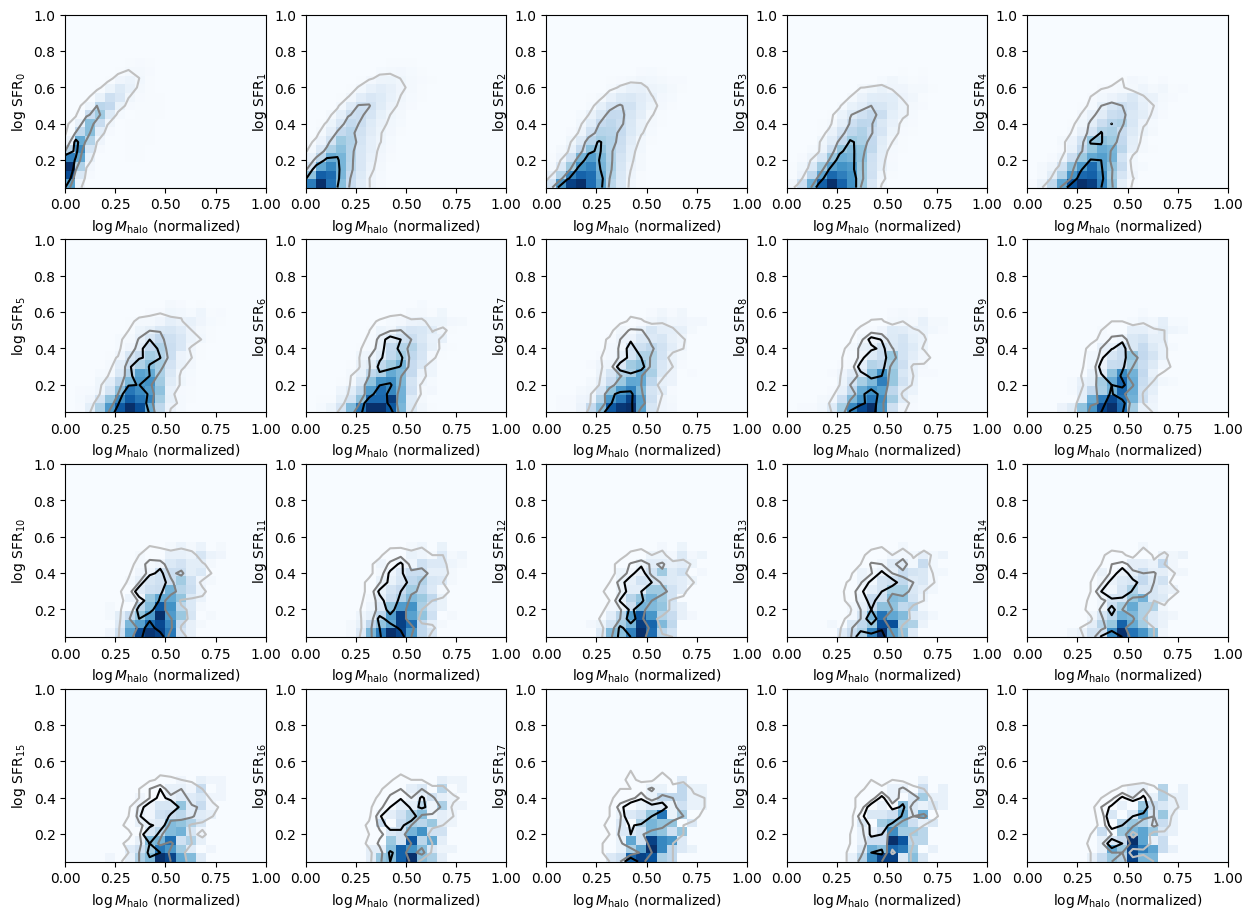

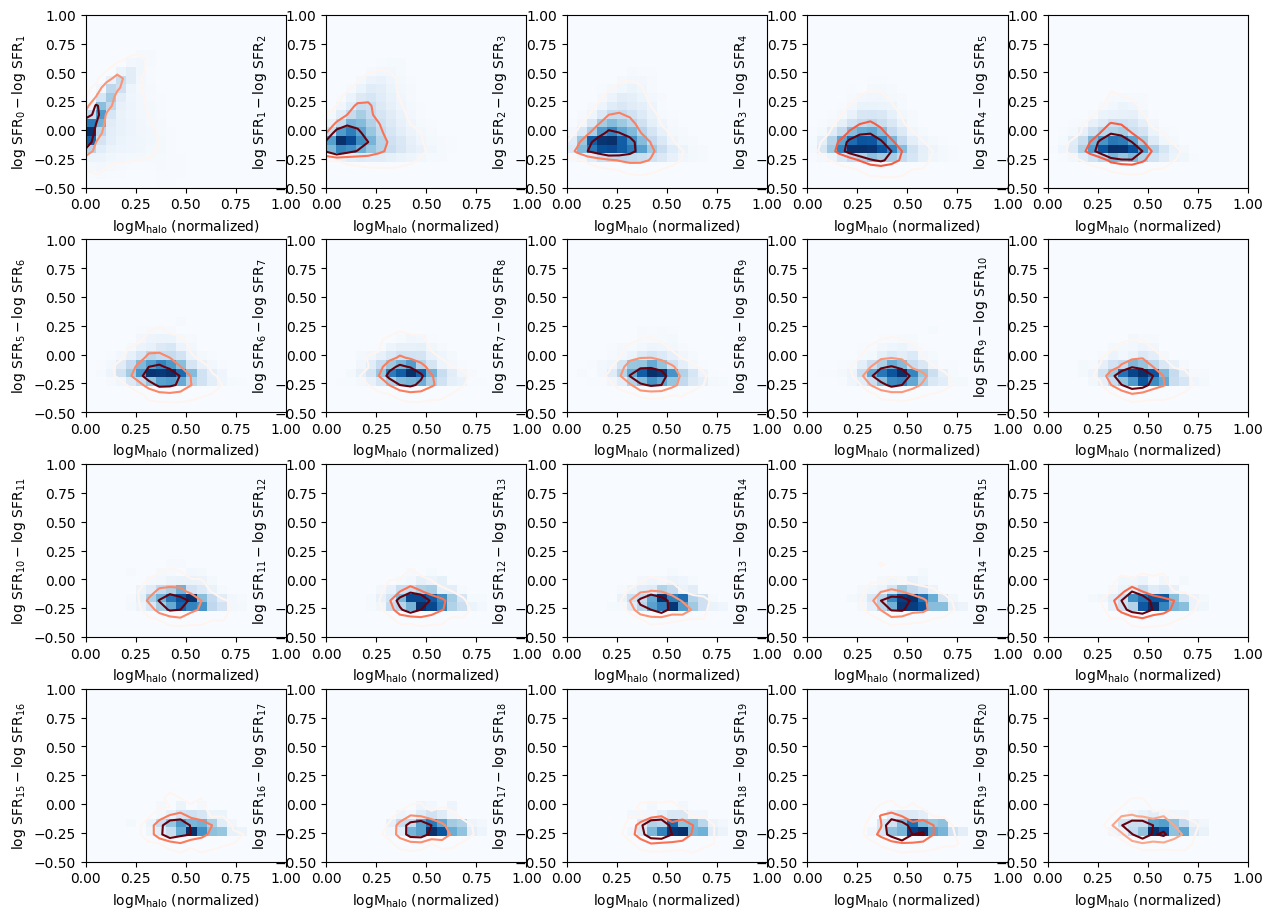

In [8]:
### comparison of M-SFR relations 
show_scatter = True
show_scatter = False

max_length_to_show = 20
param_names = [r"$\rm log\ SFR$", r"$\log \ d$"]

def compute_contoure_levels(grid_data, sigma_levels=[0.9545, 0.6827, 0.383]): #[0.9973, 0.9545, 0.6827, 0.383]
    grid_data = grid_data / np.sum(grid_data)
    grid_data_sorted = np.sort(grid_data.flatten())[::-1]
    cumsum = np.cumsum(grid_data_sorted)

    levels = [ grid_data_sorted[np.where(cumsum > sigma)[0][0]] for sigma in sigma_levels ]

    return grid_data, levels

for iparam in range(opt.num_features_in):
    xnow_true = x_true
    ynow_true = y_true
    xnow = x_true
    ynow = generated

    plt.figure(figsize=(15, 11))
    plt.subplots_adjust(wspace=0.2, hspace=0.3)
    for i in range(max_length_to_show):
        if iparam == 1 and i == 0:
            continue
        xnow_true = xnow_true[ynow_true[:,i,0]>threshold]
        ynow_true = ynow_true[ynow_true[:,i,0]>threshold]
        xnow = xnow[ynow[:,i,0]>threshold]
        ynow = ynow[ynow[:,i,0]>threshold]

        plt.subplot(4,5,i+1)    

        if show_scatter:
            plt.scatter(xnow_true, ynow_true[:,i,iparam], s=1, color="blue", alpha=0.5)
            plt.scatter(xnow, ynow[:,i,iparam], s=1, color="red", alpha=0.5)
        else:
            hist_range = [[0,1],[threshold,1]]
            extent = [0,1,threshold,1]
            hist = np.histogram2d(xnow_true, ynow_true[:,i,iparam], bins=20, range=hist_range)
            plt.imshow(hist[0].T, extent=extent, cmap="Blues", origin="lower", aspect="auto")
            grid_data, levels = compute_contoure_levels(hist[0])
            #plt.contour(grid_data.T, extent=extent, cmap="Blues", levels=levels, origin="lower")
            hist = np.histogram2d(xnow, ynow[:,i,iparam], bins=20, range=hist_range)
            grid_data, levels = compute_contoure_levels(hist[0])
            gray_colors = ['#C0C0C0', '#808080', '#000000'] 
            plt.contour(grid_data.T, extent=extent, colors=gray_colors, levels=levels)

        plt.ylabel(param_names[iparam]+r"$_{%d}$" % i)
        plt.xlabel(r"$\log M_{\rm halo}\ (\rm normalized)$")

    xnow_true = x_true
    ynow_true = y_true
    xnow = x_true
    ynow = generated
    plt.figure(figsize=(15,11))
    plt.subplots_adjust(wspace=0.2, hspace=0.3)
    for i in range(max_length_to_show):
        xnow_true = xnow_true[ynow_true[:,i,0]>threshold]
        ynow_true = ynow_true[ynow_true[:,i,0]>threshold]
        xnow = xnow[ynow[:,i,0]>threshold]
        ynow = ynow[ynow[:,i,0]>threshold]

        if i < opt.max_length - 1:
            plt.subplot(4,5,i+1)
            if show_scatter:
                plt.scatter(xnow_true, ynow_true[:,i,iparam]-ynow_true[:,i+1,iparam], s=1, color="blue", alpha=0.5)
                plt.scatter(xnow, ynow[:,i,iparam]-ynow[:,i+1,iparam], s=1, color="red", alpha=0.5)
            else:
                hist_range = [[0,1],[-0.2,0.9]]
                hist = np.histogram2d(xnow_true, ynow_true[:,i,iparam]-ynow_true[:,i+1,iparam], bins=20, range=hist_range)
                grid_data, levels = compute_contoure_levels(hist[0])
                plt.imshow(hist[0].T, extent=[0,1,-0.5,1], cmap="Blues", origin="lower", aspect="auto")
                #plt.contour(grid_data.T, extent=[0,1,-0.5,1], cmap="Blues", levels=levels5)
                hist = np.histogram2d(xnow, ynow[:,i,iparam]-ynow[:,i+1,iparam], bins=20, range=hist_range)
                grid_data, levels = compute_contoure_levels(hist[0])
                plt.contour(grid_data.T, extent=[0,1,-0.5,1], cmap="Reds", levels=levels)
            plt.ylabel(param_names[iparam]+(r"$_{%d} - $" % i) + param_names[iparam] + (r"$_{%d}$" % (i+1)))
            plt.xlabel(r"$\rm log M_{\rm halo}\ (\rm normalized)$")


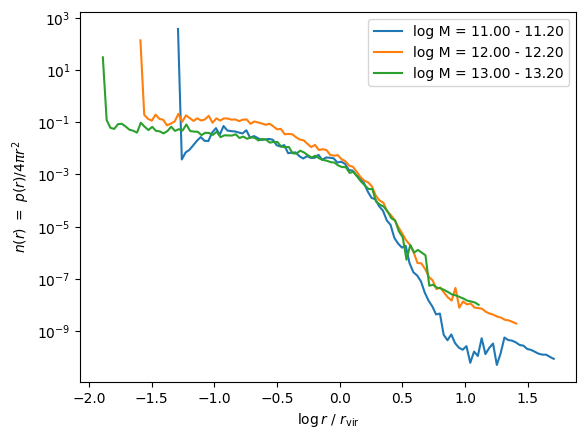

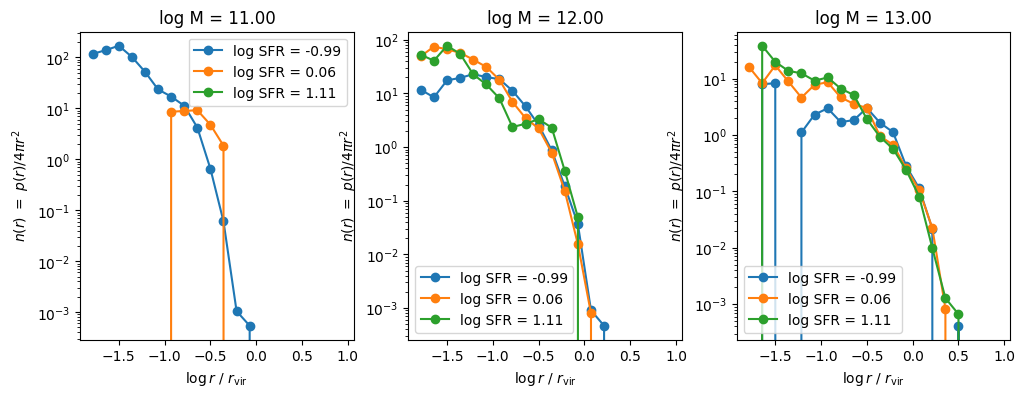

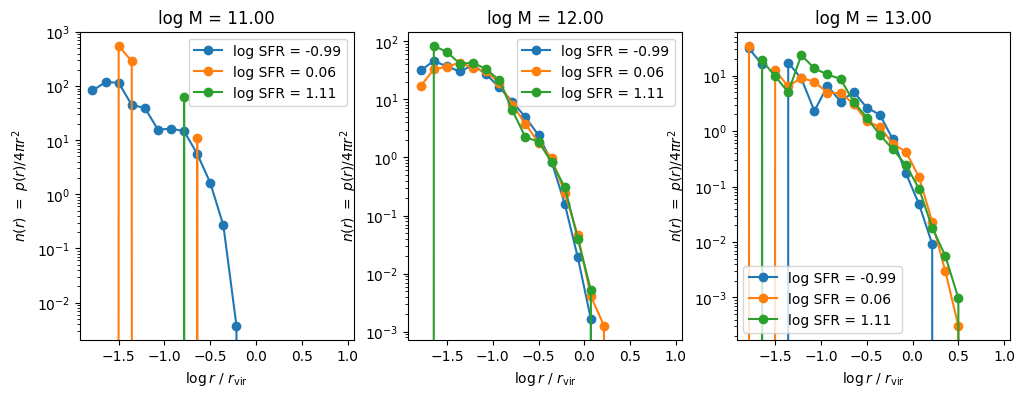

In [33]:
## radial profile
def NFW_profile(logr, log_rs=0, log_rho0=0):
    r = 10**logr 
    rs = 10**log_rs
    rho0 = 10**log_rho0
    return rho0 / (r/rs) / (1 + r/rs)**2
# concentration = rvir / rs = 1e-1 / 1 

nsample = 100

plt.figure()

list_to_show = [0, 5, 10]
for ibin in list_to_show:
    x_random = torch.rand(nsample).to(device) 
    x_random = x_random * (logm_bins[ibin+1] - logm_bins[ibin]) + logm_bins[ibin]
    generated_test, prob = model.generate(x_random)
    generated_test = generated_test.detach().cpu().numpy()
    prob = prob.detach().cpu().numpy()
    length_generated_test = calc_length(generated_test)

    r_profile = np.zeros(opt.num_features_out)
    count = 0
    for i, (x, g) in enumerate(zip(x_random, generated_test)):
        iparam = 1
        for k in range(1, length_generated_test[i]+1):
            r_profile += prob[i,k,iparam]
            count += 1
    logr = np.linspace(0, 1, opt.num_features_out) * (ymax2 - ymin2) + ymin2
    r_profile /= count * 4 * np.pi * ( 10 ** logr ) ** 2

    logr_vir = np.log10( 0.39 ) + 0.3 * ( logm_bins_Msun[ibin] - 12 )

    logr = logr - logr_vir

    plt.plot(logr, r_profile, label=f"log M = {logm_bins_Msun[ibin]:.2f} - {logm_bins_Msun[ibin+1]:.2f}")
    
plt.yscale("log")
plt.ylabel(r"$n (r) \ = \ p(r) / 4\pi r^2$")
plt.xlabel(r"$\log r\ /\ r_{\rm vir} $")
#plt.xlabel(r"$\log r \ [{\rm Mpc}/h]$")
plt.legend()



list_to_show = [0, 5, 10]
y_list_to_show = [1, 6, 11]

plt.figure(figsize=(len(list_to_show)*4, 4))
for count, i_logm in enumerate(list_to_show):
    plt.subplot(1, len(list_to_show), count+1)
    plt.title(f"log M = {logm_bins_Msun[i_logm]:.2f}")
    base_mask = (logm_bin_indices_true == i_logm)
    for j in y_list_to_show:
        ynow = y_true[base_mask]
        bin_indices_now = np.digitize(ynow[:,:,0], y_bins) - 1 
        ynow = ynow[bin_indices_now == j]

        hist, bins = np.histogram(ynow[:,1], range=(threshold,1), bins=20, density=True)
        logr = bins * (ymax2 - ymin2) + ymin2
        logr = 0.5 * (logr[1:] + logr[:-1])
        hist /= 4 * np.pi * ( 10 ** logr ) ** 2

        plt.plot(logr, hist, label=f"log SFR = {y_bins_Msun_yr[j]:.2f}", ls="-", marker="o")

    plt.yscale("log")
    plt.legend()
    plt.ylabel(r"$n (r) \ = \ p(r) / 4\pi r^2$")
    plt.xlabel(r"$\log r\ /\ r_{\rm vir} $")


plt.figure(figsize=(len(list_to_show)*4, 4))
for count, i_logm in enumerate(list_to_show):
    plt.subplot(1, len(list_to_show), count+1)
    plt.title(f"log M = {logm_bins_Msun[i_logm]:.2f}")
    base_mask = (logm_bin_indices_true == i_logm)
    for j in y_list_to_show:
        ynow = generated[base_mask]
        bin_indices_now = np.digitize(ynow[:,:,0], y_bins) - 1 
        ynow = ynow[bin_indices_now == j]

        hist, bins = np.histogram(ynow[:,1], range=(threshold,1), bins=20, density=True)
        logr = bins * (ymax2 - ymin2) + ymin2
        logr = 0.5 * (logr[1:] + logr[:-1])
        hist /= 4 * np.pi * ( 10 ** logr ) ** 2

        plt.plot(logr, hist, label=f"log SFR = {y_bins_Msun_yr[j]:.2f}", ls="-", marker="o")

    plt.yscale("log")
    plt.legend()
    plt.ylabel(r"$n (r) \ = \ p(r) / 4\pi r^2$")
    plt.xlabel(r"$\log r\ /\ r_{\rm vir} $")


Text(0, 0.5, 'log d')

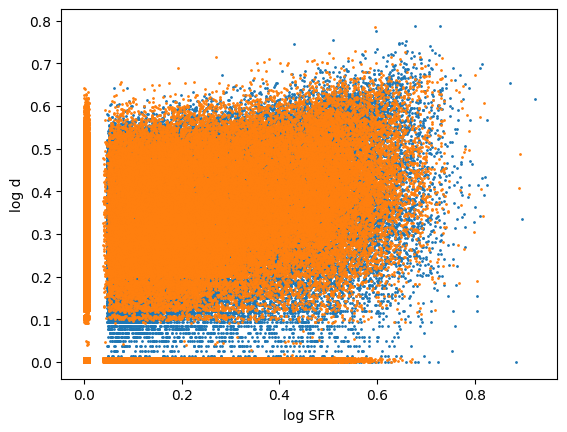

In [9]:
### Relation between SFR_0 and d_0
plt.figure()
plt.scatter(y_true[:,1,0], y_true[:,1,1], s=1)
plt.scatter(generated[:,1,0], generated[:,1,1], s=1)

plt.xlabel("log SFR")
plt.ylabel("log d")

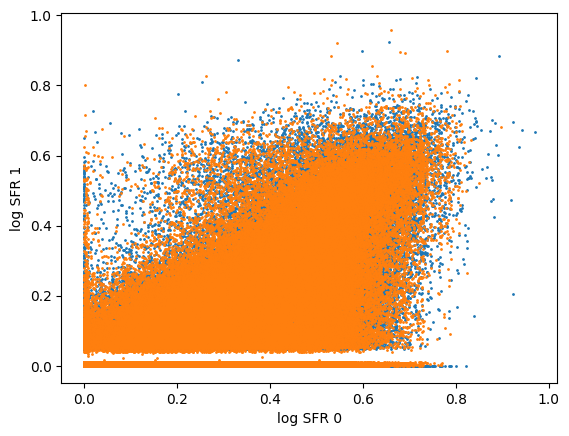

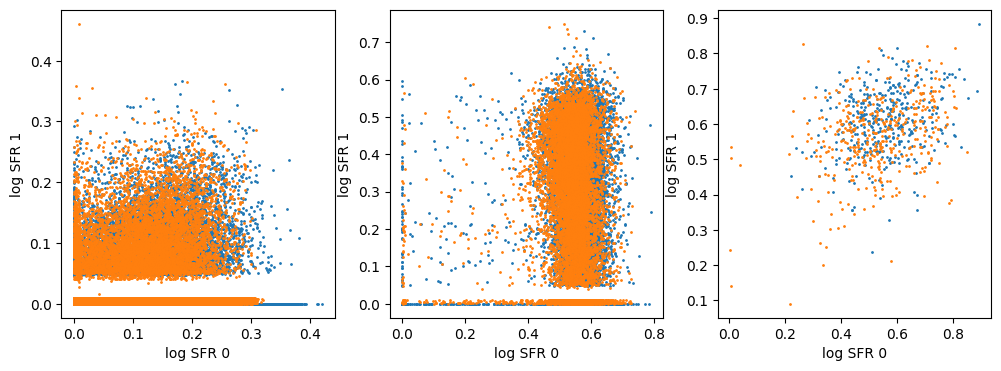

In [12]:
### Relation between SFR_0 and SFR_1 etc.
plt.figure()
plt.scatter(y_true[:,0,0], y_true[:,1,0], s=1)
plt.scatter(generated[:,0,0], generated[:,1,0], s=1)
plt.xlabel("log SFR 0")
plt.ylabel("log SFR 1")

list_to_show = [0, 5, 10]

plt.figure(figsize=(len(list_to_show)*4, 4))
for count, ihalo in enumerate(list_to_show):
    mask = (logm_bin_indices_true == ihalo)
    plt.subplot(1,len(list_to_show),count+1)
    plt.scatter(y_true[mask,0,0], y_true[mask,1,0], s=1)
    plt.scatter(generated[mask,0,0], generated[mask,1,0], s=1)
    plt.xlabel("log SFR 0")
    plt.ylabel("log SFR 1")

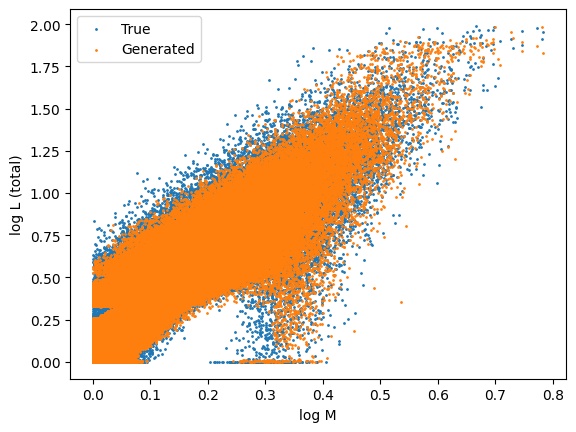

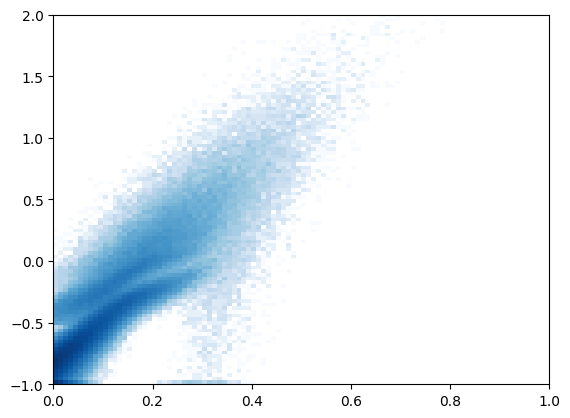

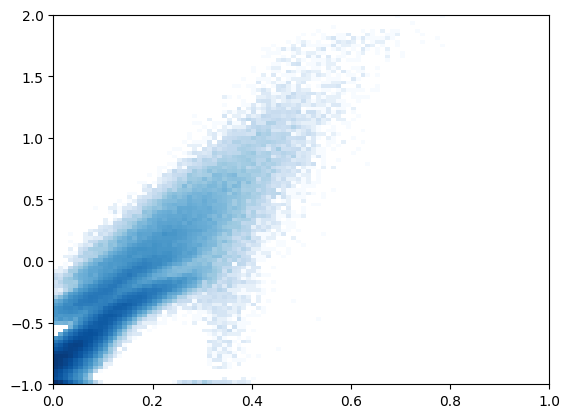

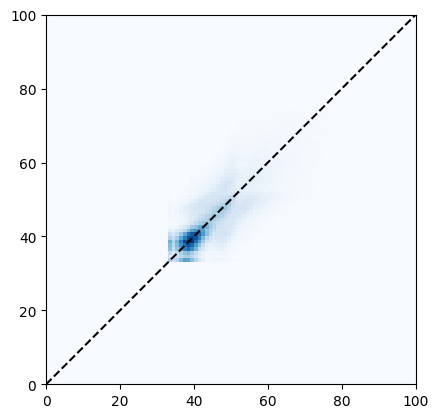

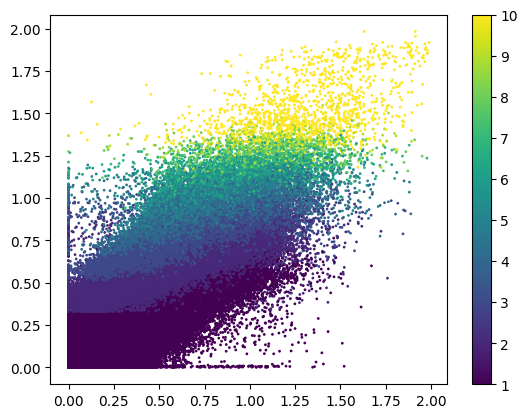

In [11]:
### True total vs generated total

plt.figure()
plt.scatter(x_true, y_true_tot, s=1, label="True")
plt.scatter(x_true, y_generated_tot, s=1, label="Generated") 
plt.xlabel("log M")
plt.ylabel("log L (total)")
plt.legend()

plt.figure()
hist = np.histogram2d(x_true, y_true_tot, bins=100, range=[[0,1],[0,2]])
plt.imshow(hist[0].T, extent=[0,1,-1,2], origin="lower", cmap="Blues", aspect="auto", norm=LogNorm())

plt.figure()
hist = np.histogram2d(x_true, y_generated_tot, bins=100, range=[[0,1],[0,2]])
plt.imshow(hist[0].T, extent=[0,1,-1,2], origin="lower", cmap="Blues", aspect="auto", norm=LogNorm())


plt.figure()

hist = np.histogram2d(y_true_tot, y_generated_tot, bins=100, range=[[-1,2],[-1,2]])
plt.imshow(hist[0].T, extent=[0,100,0,100], origin="lower", cmap="Blues")
plt.plot([0, 100], [0, 100], color="black", ls="--")

plt.figure()
plt.scatter(y_true_tot, y_generated_tot, c=length_generated, s=1, vmin=1, vmax=10)
plt.colorbar()


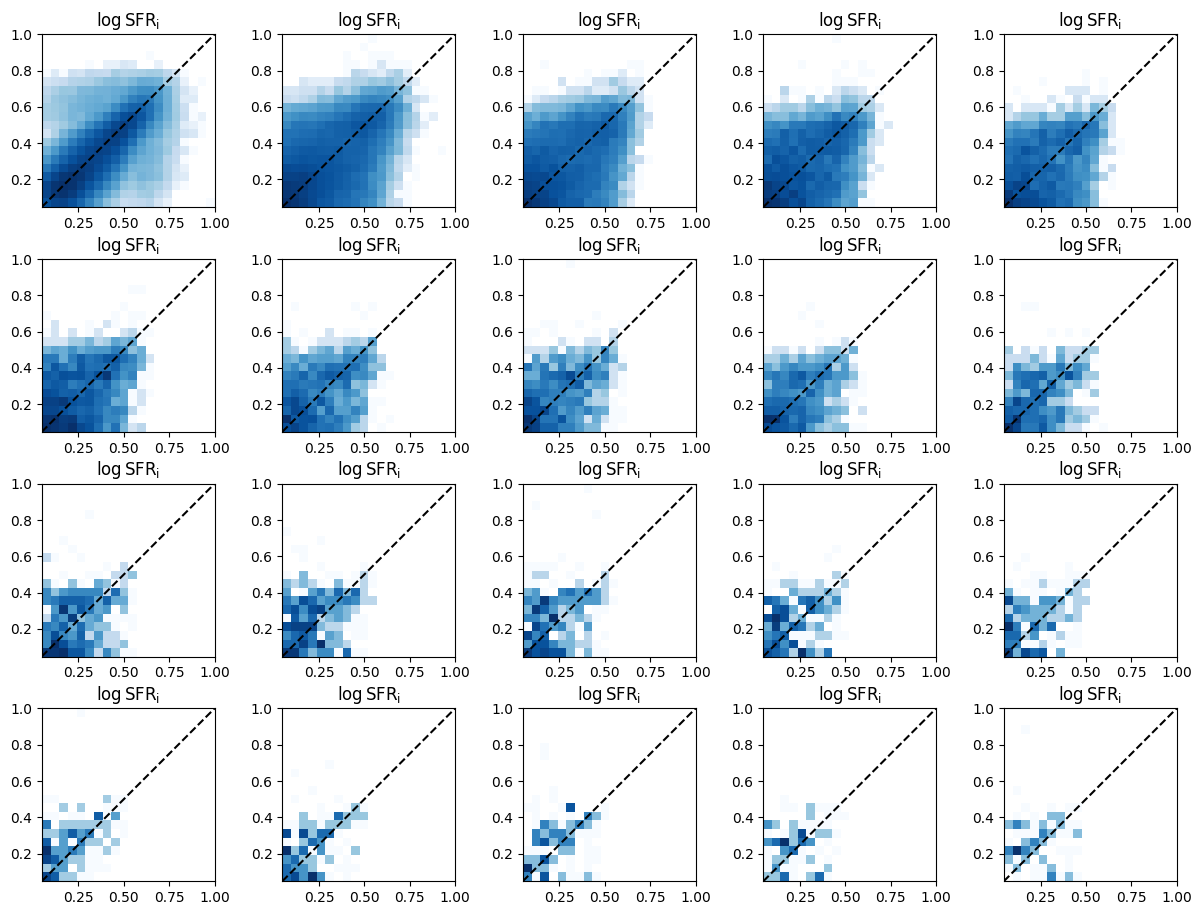

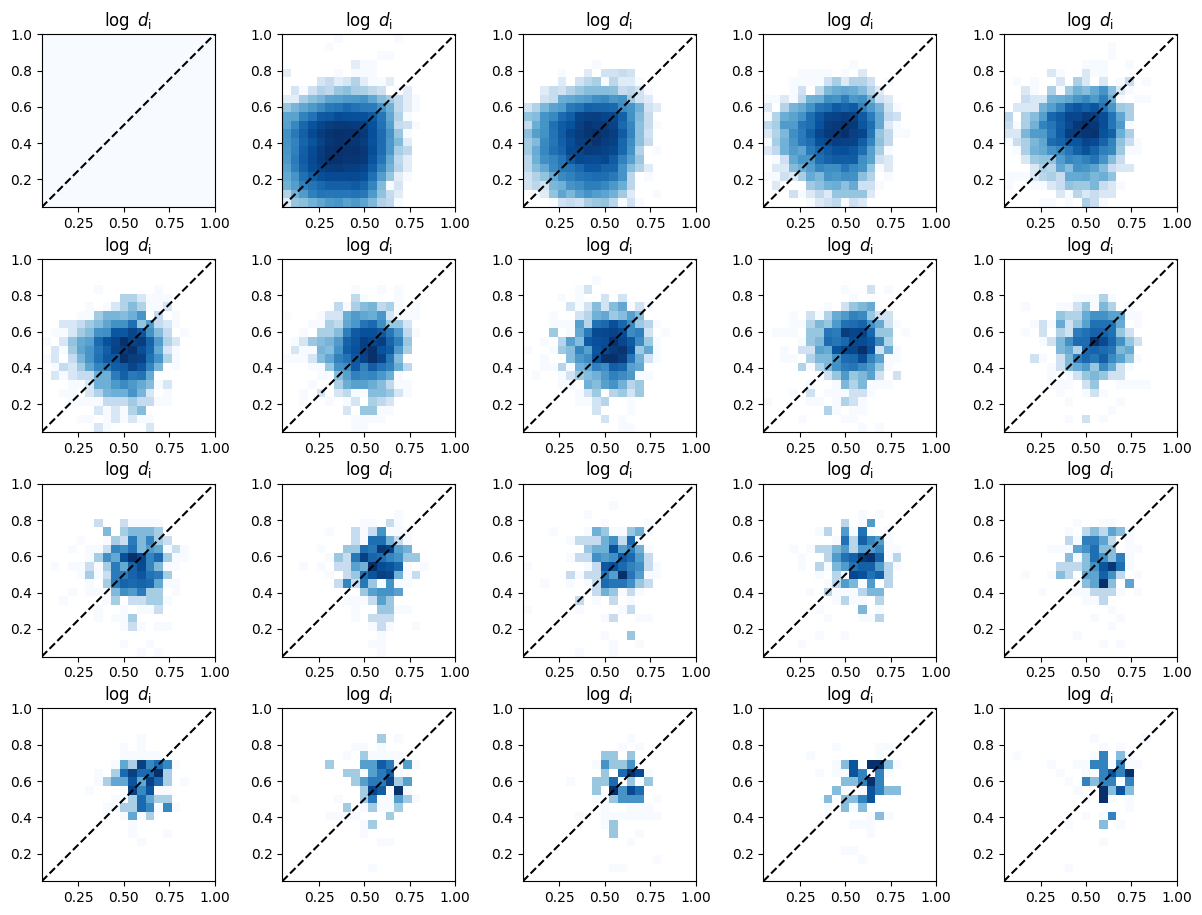

In [24]:
### True vs generated 
show_scatter = False #True

for iparam in range(2):
    plt.figure(figsize=(15,11))
    plt.subplots_adjust(wspace=0.2, hspace=0.3)
    for i in range(20):
        plt.subplot(4, 5, i+1)
        if iparam == 0:
            plt.title(r"$\rm \log SFR_{i}$")
        if iparam == 1:
            plt.title(r"$\log \ d_{\rm i}$")

        if show_scatter:
            plt.scatter(y_true[:,i,iparam], generated[:,i,iparam], s=1) #, c=length_generated, vmin=1, vmax=10)
        else:
            hist = np.histogram2d(y_true[:,i,iparam], generated[:,i,iparam], bins=20, range=[[threshold,1],[threshold,1]])
            plt.imshow(hist[0].T, extent=[threshold,1,threshold,1], origin="lower", cmap="Blues", norm=LogNorm())

        plt.plot([threshold, 1], [threshold, 1], color="black", ls="--")
        #plt.colorbar()
        plt.xlim(threshold, 1)
        plt.ylim(threshold, 1)


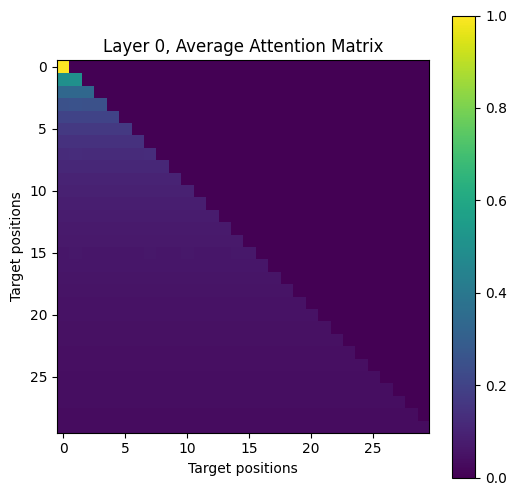

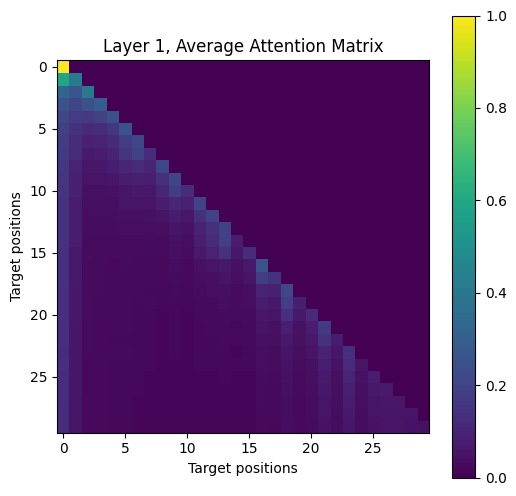

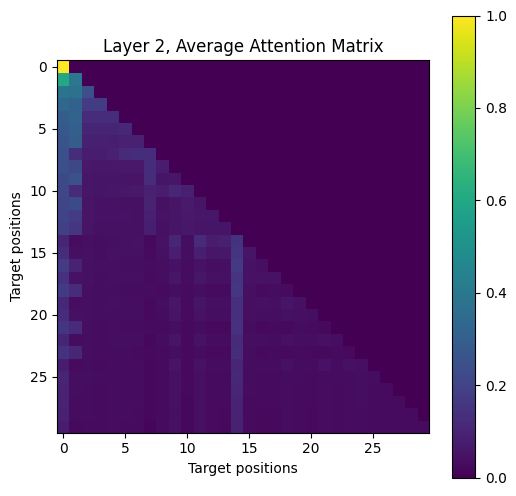

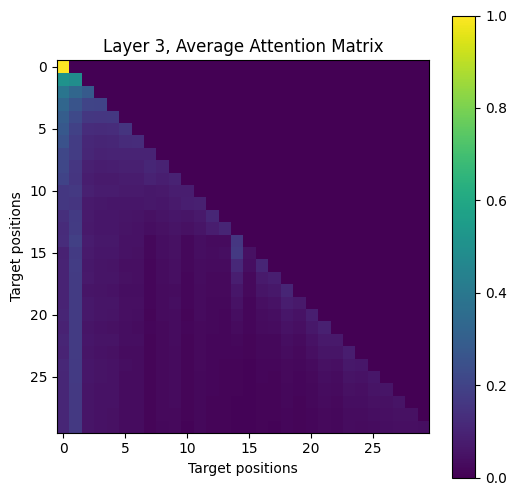

In [9]:
### Transformer attention visualization

opt_now = copy.deepcopy(opt)
opt_now.model_name = opt.model_name + "_with_attn"
model_now = my_model(opt_now)
model_now.to(device)

model_now.load_state_dict(torch.load(f"{model_dir}/model.pth"))
model_now.eval()

attn_weights = {}

def get_hook(name):
    def hook(module, input, output):
        attn_weights[name] = output[1].detach().cpu() 
    return hook

for i, layer in enumerate(model_now.decoder.layers):
    layer.self_attn.register_forward_hook(get_hook(f'layer_{i}_self_attn'))

con = torch.from_numpy(x_true[0:1]).unsqueeze(-1).to(device)
seq = torch.from_numpy(y_true[0:1,:-1,:]).to(device)

output = model_now(con, seq)

for i in range(opt_now.num_layers):
    attn_matrix = attn_weights[f'layer_{i}_self_attn'][0].numpy()  # (tgt_len, tgt_len)

    plt.figure(figsize=(6, 6))
    plt.imshow(attn_matrix, cmap='viridis')
    plt.colorbar()
    plt.title(f"Layer {i}, Average Attention Matrix")
    plt.xlabel("Target positions")
    plt.ylabel("Target positions")
    plt.show()


In [3]:
data_dir = "./TNG_data"
snapshot_number = 38
file_path = os.path.join(data_dir, f"group.central-satellite.{snapshot_number}.txt")
file_path2 = os.path.join(data_dir, f"group.central-satellite.vrad.{snapshot_number}.txt")

xmin = 11
ymin = -1

max_length = 10
count = 0

x_list = []
y_list = []
with open(file_path, 'r') as f, open(file_path2, "r") as f2:
    
    for line, line2 in zip(f, f2):
        line = line.strip()
        line2 = line2.strip()

        if not line or line.startswith("#"):
            continue
        
        tokens = line.split()
        tokens2 = line2.split()

        ### halo mass
        try:
            m_val = float(tokens[0])
        except ValueError:
            continue  

        if m_val < xmin:
            continue

        if np.abs( float(tokens2[0]) - m_val ) > 1e-4:
            raise ValueError("Mass values are not consistent!")
        
        ### central luminosity
        try:
            y_central = float(tokens[1])
            y2_central = float(tokens2[1])
            if y_central < ymin:
                y_central = ymin
        except ValueError:
            y_central = ymin
            y2_central = ymin2

        ### satellite luminosities
        try:
            y_values = [float(tok) for tok in tokens[2:]]
            y2_values = [float(tok) for tok in tokens2[2:]]
        except ValueError:
            y_values = []
            y2_values = []

        y_values = [y_central] + y_values
        y2_values = [y2_central] + y2_values

        ### truncate
        y_values = y_values[:max_length]
        y2_values = y2_values[:max_length]

        x_list.append(m_val)
        y = np.array([y_values, y2_values], dtype=np.float32)
        y = np.transpose(y, (1, 0))
        y_list.append(y)

        count += 1

x = np.array(x_list)
y_padded = np.zeros((len(x_list), max_length, 2))
for i, y_i in enumerate(y_list):
    y_padded[i, :len(y_i), :] = y_i


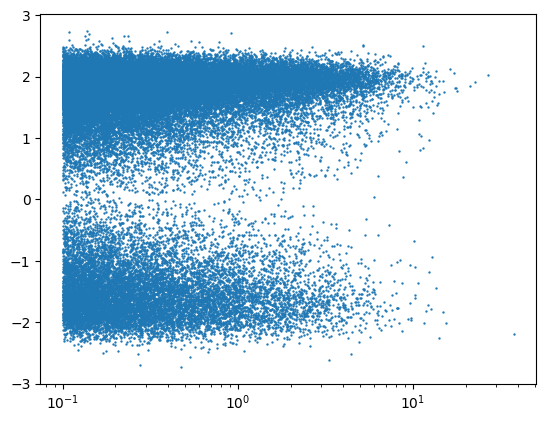

In [6]:
mask = (x > 11) & (x < 12)
_y = y_padded[:,1,0]
_y = _y[mask]
_y2 = y_padded[:,1,1]
_y2 = _y2[mask] 
_y2 = np.sign(_y2) * np.log10(np.abs(_y2)+1)
_x = x[mask]
plt.scatter(_y, _y2, s=0.5)
plt.xscale("log")
#plt.yscale("log")